# Model Comparison with Pareto Smoothed Importance Sampling CV

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from theano import shared
import arviz as az

### What is PSIS CV?
#### PSIS uses importance sampling (i.e. importance weights) and a smoothing technique to make the importance weights more reliable. 

#### Cross validation estimates the out of sample log pointwise predictive density (lppd). If you have N obs and fit the model N times, dropping a single observation $y_{i}$ each time (i.e. leave one out) then the out of sample lppd is the sum of the average accuracy for each omitted $y_{i}$:

$$lppd_{cv} = \sum_{i=1}^{N}1/S\sum_{s=1}^{S}logPr(y_{i}\theta_{-i,s})$$

#### Where $s$ indexes samples from a Markov chain and $\theta_{-i,s})$ is the s-th sample from the posterior computed for obs omitting $y_{i}$. 

#### importance sampling replaces the computation of N posterior distributions by using an estimate of the importance of each i to the posterior distribution. We draw a samples from the full posterior distribution $p(\theta|y)$, but we want samples from the reduced leave-one-out posterior distribution $p(\theta|y_{i})$, then we need to re-weight each sample s by the inverse of the probability of the omitted observation:

$$r(\theta_{s}) = 1/(p(y_{i}|\theta_{s})$$

#### The weight is normalised inside the following calc:

$$lppd_{is} = \sum_{i=1}^{N}log\sum_{i=1}^{S}r(\theta_{s})p(y_{i}|\theta_{s})/\sum_{i=1}^{S}r(\theta_{i})$$

#### Pareto Smoothing enters in as $r(\theta_{s})$ can be unreliable particular if any $r(\theta_{s})$ is too large relatively speaking and thus ruins the lppd estimate. PSIS exploits the fact that the distribution of weights should have a particular Pareto Distribution shape under some regular conditions:

$$p(r|\mu, \sigma,\kappa) = \sigma^{-1}(1+\kappa(r-\mu)\sigma^{-1})^{-1/\kappa - 1}$$

In [5]:
def data_proc():
    
    def standardise(x):
        return (x-x.mean())/x.std()
    
    data = pd.read_csv(os.path.join(os.getcwd(),r'data/waffle_divorce.csv'), delimiter=";")
    data['A'] = standardise(data['MedianAgeMarriage'])
    data['M'] = standardise(data['Marriage'])
    data['D'] = standardise(data['Divorce'])
    
    return data

In [6]:
data = data_proc()

In [9]:
with pm.Model() as m_5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    
    mu = a + bA*data.A
    sigma = pm.Exponential("sigma", 1)
    
    D = pm.Normal("D", mu, sigma, observed=data.D)
    
    m_5_1_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [11]:
with pm.Model() as m_5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    
    mu = a + bM*data.M
    sigma = pm.Exponential("sigma", 1)
    
    D = pm.Normal("D", mu, sigma, observed=data.D)
    
    m_5_2_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [13]:
with pm.Model() as m_5_3:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    
    mu = a + bA*data.A + bM*data.M 
    sigma = pm.Exponential("sigma", 1)
    
    D = pm.Normal("D", mu, sigma, observed=data.D)
    
    m_5_3_trace = pm.sample(return_inferencedata=True, tune=1_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [23]:
for i in [m_5_1_trace, m_5_2_trace, m_5_3_trace]:
    print(pm.summary(i))
    print("\n")

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a      0.000  0.102  -0.185    0.193      0.001    0.002    5117.0    3002.0   
bA    -0.566  0.116  -0.782   -0.347      0.002    0.001    5206.0    2900.0   
sigma  0.824  0.087   0.673    0.991      0.001    0.001    4744.0    2610.0   

       r_hat  
a        1.0  
bA       1.0  
sigma    1.0  


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a     -0.000  0.115  -0.199    0.231      0.002    0.002    4368.0    2836.0   
bM     0.345  0.128   0.122    0.591      0.002    0.001    5136.0    3081.0   
sigma  0.949  0.095   0.786    1.139      0.001    0.001    5113.0    3105.0   

       r_hat  
a        1.0  
bM       1.0  
sigma    1.0  


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a     -0.002  0.100  -0.180    0.190      0.002    0.002    2968.0    2285.0   
bA    -0.612  0.159  -0.910   -0.313      0.003    0.002    2287.0    2070

In [24]:
az.compare({"m_5_1": m_5_1_trace, "m_5_2": m_5_2_trace, "m_5_3": m_5_3_trace}, scale="deviance")

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less lik

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m_5_1,0,126.249371,3.892044,0.000000,0.88998,12.909642,0.000000,True,deviance
m_5_3,1,128.048360,5.003556,1.798989,0.00000,13.132776,0.807311,True,deviance
m_5_2,2,139.177323,2.877189,12.927953,0.11002,9.767951,9.446769,False,deviance


#### Comment, there are small differences in deviance between the models (see DSE). More interestingly we receive an error related to the shape param of the Pareto distribution (governed by K in the above equation). This suggests that there are highly influential observations impacting the out of sample predictive accuracy. 

In [26]:
def plotter(model_trace):
    psis = az.loo(model_trace, pointwise=True, scale="deviance")
    waic = az.waic(model_trace, pointwise=True, scale="deviance")
    
    plt.scatter(psis.pareto_k, waic.waic_i)
    plt.xlabel("PSIS Pareto k")
    plt.ylabel("WAIC")
    plt.show()

#### Plotting the pareto k and WAIC penalty term we can see a clear outlier, this point corresponds to the state of Idaho which has a very low divorce rate for its age at marriage. It is highly influential and therefore exerts more influence on the posterior distribution than the other states.

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


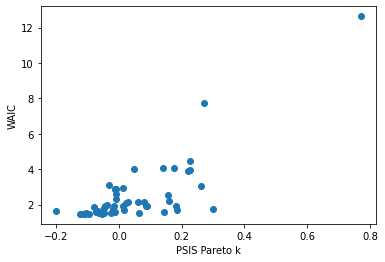

In [27]:
plotter(m_5_3_trace)

#### What to do? Note that a Gaussian error distribution is going to be easily surprised with very thin tails, meaning that very little probability mass is given to observations far from the mean. Let's instead consider a student T distribution which assigns more probability to extreme events.

No handles with labels found to put in legend.


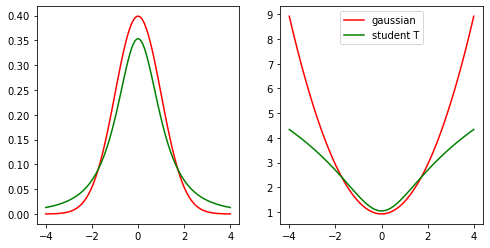

In [32]:
x = np.linspace(-4, 4, 100)
gaussian = stats.norm(0, 1)
student_t = stats.t(df=2, loc=0, scale=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[8, 4])
ax1.plot(x, gaussian.pdf(x), color="r", label="gaussian")
ax1.plot(x, student_t.pdf(x), color="g", label="student T")


ax2.plot(x, -gaussian.logpdf(x), color="r", label="gaussian")
ax2.plot(x, -student_t.logpdf(x), color="g", label="student T")
plt.legend()


#### Using the student's T distribution we can deploy a robust regression. The thickness of the tails is controlled by the additional shape parameter $v$. As $v$ approaches 1 the tails get a lot thicker however as $v \rightarrow \infty$ the T distribution converges to a Gaussian.

In [36]:
with pm.Model() as m_5_3t:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    
    mu = a + bA*data.A + bM*data.M 
    sigma = pm.Exponential("sigma", 1)
    
    D = pm.StudentT("D", 2, mu, sigma, observed=data.D)
    
    m_5_3t_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


#### Note there are no warnings now and the relative influence of Idaho has been reduced. The coefficient for bA is a lot stronger now since Idaho has a low divorce rate and low median age at marriage. When it was influential it reduced the association between age at marriage and divorce, now it is less influential so the association is estimated to be larger.

In [37]:
pm.summary(m_5_3t_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.023,0.103,-0.158,0.231,0.002,0.002,2997.0,2571.0,1.0
bA,-0.690,0.152,-0.988,-0.419,0.003,0.002,3209.0,2733.0,1.0
bM,0.048,0.207,-0.314,0.448,0.004,0.003,3266.0,2673.0,1.0
sigma,2.753,0.772,1.377,4.165,0.012,0.009,3891.0,2802.0,1.0


In [34]:
az.loo(m_5_3t_trace, pointwise=True, scale="deviance")

Computed from 4000 by 50 log-likelihood matrix

             Estimate       SE
deviance_loo   132.26    10.63
p_loo            5.32        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       50  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

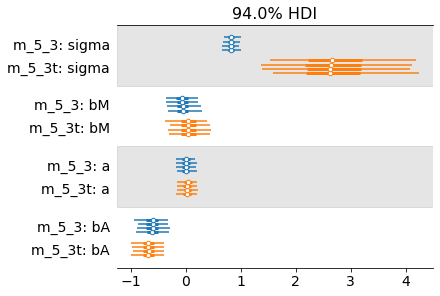

In [35]:
az.plot_forest([m_5_3_trace, m_5_3t_trace], model_names=["m_5_3", "m_5_3t"], figsize=[6,4])